In [1]:
# import lib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
# cross-validation
from sklearn.model_selection import cross_val_score
# import warnings
# warnings.filterwarnings('ignore')


In [3]:
#  DATA LOADING AND PREPROCESSING

In [4]:
df = pd.read_csv("../data/german.data", sep=' ', header=None)
df.columns = [
    'status', 'duration', 'credit_history', 'purpose', 'amount',
    'savings', 'employment', 'installment_rate', 'personal_status',
    'debtors', 'residence', 'property', 'age', 'other_plans',
    'housing', 'existing_credits', 'job', 'dependents', 'telephone', 'foreign', 'risk'
]

# Map risk: 1=Good, 2=Bad -> 0=Good, 1=Bad
df['risk'] = df['risk'].map({1: 0, 2: 1})
df.to_csv("../data/german_processed.csv", index=False)

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print("First 5 rows:")
print(df.head())

print("\nTarget distribution:")
print(df['risk'].value_counts())
print(f"Default rate: {df['risk'].mean():.2%}")

Dataset shape: (1000, 21)
Missing values: 0
First 5 rows:
  status  duration credit_history purpose  amount savings employment  \
0    A11         6            A34     A43    1169     A65        A75   
1    A12        48            A32     A43    5951     A61        A73   
2    A14        12            A34     A46    2096     A61        A74   
3    A11        42            A32     A42    7882     A61        A74   
4    A11        24            A33     A40    4870     A61        A73   

   installment_rate personal_status debtors  ...  property age  other_plans  \
0                 4             A93    A101  ...      A121  67         A143   
1                 2             A92    A101  ...      A121  22         A143   
2                 2             A93    A101  ...      A121  49         A143   
3                 2             A93    A103  ...      A122  45         A143   
4                 3             A93    A101  ...      A124  53         A143   

  housing existing_credits   job d

In [5]:
# EXPLORATORY DATA ANALYSIS


 Exploratory Data Analysis


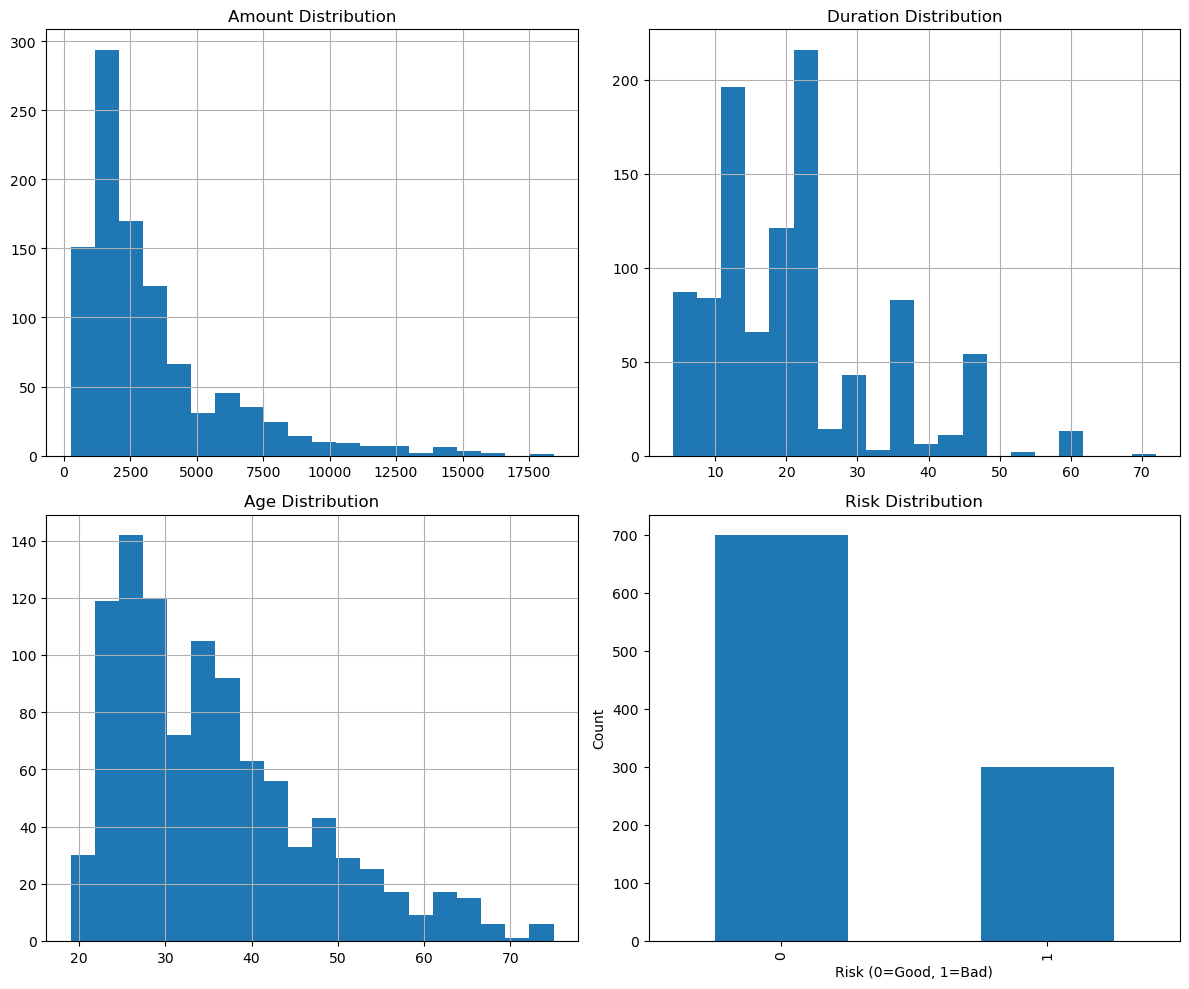

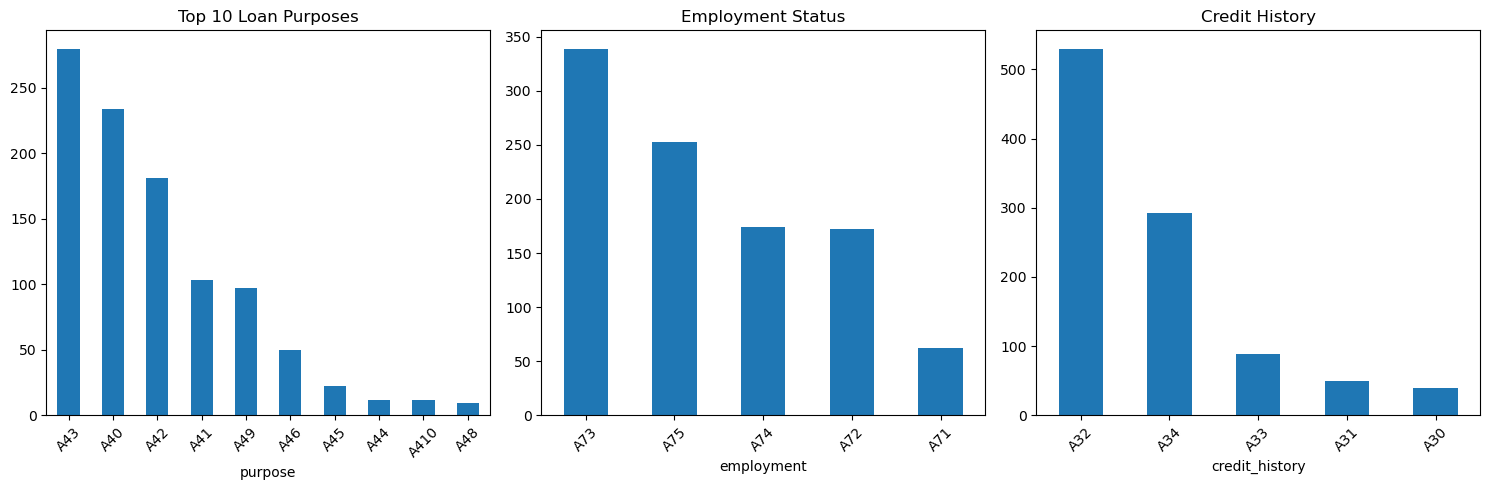

In [6]:
print("\n Exploratory Data Analysis")

# Plot numerical features
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

df[['amount', 'duration', 'age']].hist(bins=20, ax=axes[:2].flatten()[:3], figsize=(12, 8))
axes[0,0].set_title('Amount Distribution')
axes[0,1].set_title('Duration Distribution') 
axes[1,0].set_title('Age Distribution')

# Risk distribution
df['risk'].value_counts().plot(kind='bar', ax=axes[1,1], title='Risk Distribution')
axes[1,1].set_xlabel('Risk (0=Good, 1=Bad)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Plot top categorical features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['purpose'].value_counts().head(10).plot(kind='bar', title='Top 10 Loan Purposes')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
df['employment'].value_counts().plot(kind='bar', title='Employment Status')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
df['credit_history'].value_counts().plot(kind='bar', title='Credit History')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [7]:
#  FEATURE ENGINEERING AND PREPROCESSING

In [8]:
print("\n Feature Engineering and Preprocessing")

# Separate features and target
X = df.drop('risk', axis=1)
y = df['risk']

# Identify feature types
numeric_features = ['amount', 'duration', 'age', 'installment_rate', 'residence', 
                   'existing_credits', 'dependents']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Fit preprocessor and transform data
X_processed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = (numeric_features + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

print(f"Total features after preprocessing: {len(feature_names)}")
# feature se;ection
print("\nFeature Selection")

selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X_processed, y)

# Update feature names for selected features
selected_indices = selector.get_support(indices=True)
selected_feature_names = [feature_names[i] for i in selected_indices]
print(f"Selected {len(selected_feature_names)} best features:")
for i, feature in enumerate(selected_feature_names, 1):
    print(f"  {i}. {feature}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")



 Feature Engineering and Preprocessing
Numeric features (7): ['amount', 'duration', 'age', 'installment_rate', 'residence', 'existing_credits', 'dependents']
Categorical features (13): ['status', 'credit_history', 'purpose', 'savings', 'employment', 'personal_status', 'debtors', 'property', 'other_plans', 'housing', 'job', 'telephone', 'foreign']
Total features after preprocessing: 48

Feature Selection
Selected 15 best features:
  1. amount
  2. duration
  3. age
  4. status_A12
  5. status_A14
  6. credit_history_A31
  7. credit_history_A34
  8. purpose_A41
  9. purpose_A43
  10. savings_A64
  11. savings_A65
  12. employment_A72
  13. property_A124
  14. other_plans_A143
  15. housing_A152
Training set: (800, 48)
Test set: (200, 48)


In [9]:
 # MODEL TRAINING

In [10]:
print("\n Training XGBoost Model")

# Calculate class weights for imbalanced data
scale_pos_weight = sum(y == 0) / sum(y == 1)
print(f"Scale pos weight (for imbalanced data): {scale_pos_weight:.2f}")

# Train XGBoost model
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=4,  # Reduce overfitting
    learning_rate=0.1,  # Control learning
    n_estimators=100,
    subsample=0.8,  # Reduce variance
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Model training completed!")


 Training XGBoost Model
Scale pos weight (for imbalanced data): 2.33
Model training completed!


In [11]:
 # MODEL EVALUATION


 Model Evaluation
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       140
           1       0.59      0.68      0.63        60

    accuracy                           0.76       200
   macro avg       0.72      0.74      0.73       200
weighted avg       0.77      0.76      0.76       200

ROC-AUC Score: 0.7955


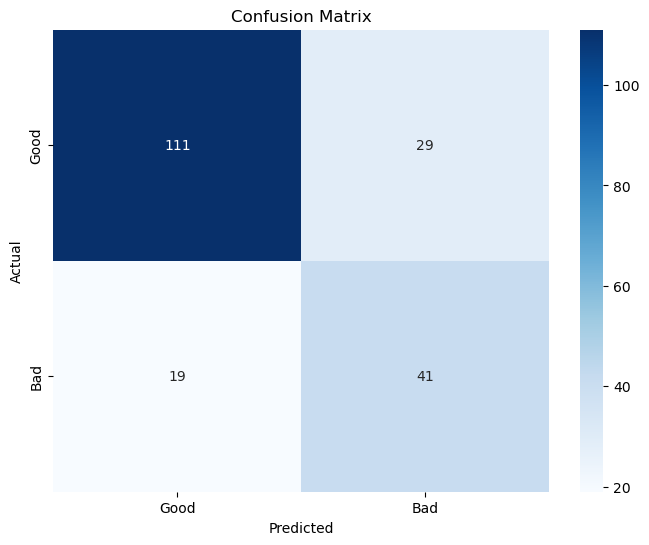


Cross-Validation Results:
CV ROC-AUC: 0.7868 (+/- 0.0322)


In [12]:
print("\n Model Evaluation")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-Validation Results:")
print(f"CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

In [13]:
# FEATURE IMPORTANCE ANALYSIS


 FEATURE IMPORTANCE ANALYSIS
TOP 15 MOST IMPORTANT FEATURES:
               feature  importance
9           status_A14    0.091409
27      employment_A72    0.036582
34        debtors_A102    0.034664
13  credit_history_A34    0.031731
10  credit_history_A31    0.030328
25         savings_A64    0.029508
1             duration    0.028654
19         purpose_A45    0.028620
20         purpose_A46    0.027607
38       property_A124    0.027348
12  credit_history_A33    0.026614
40    other_plans_A143    0.026293
7           status_A12    0.026004
35        debtors_A103    0.024536
17         purpose_A43    0.024459


C:\Users\Acer\AppData\Local\Temp\ipykernel_15212\1152134248.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


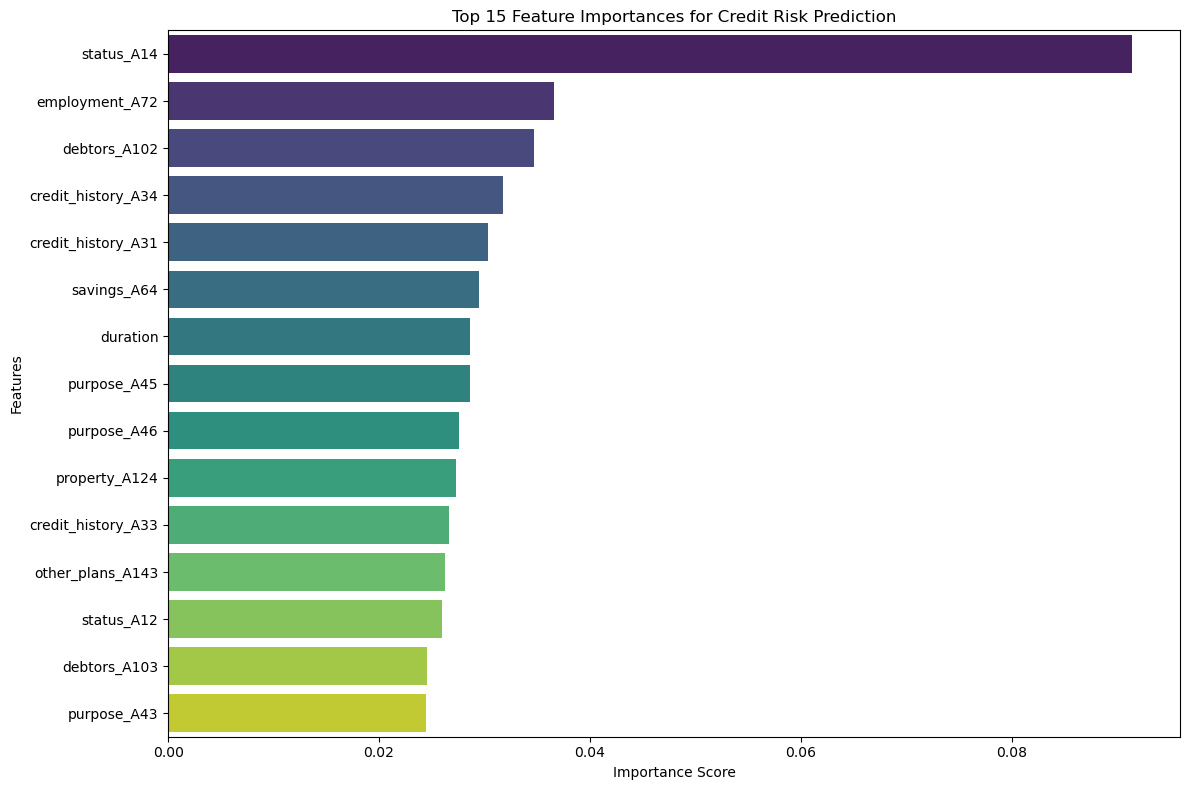

Feature Importance by Category:
Top Numeric Features:
            feature  importance
1          duration    0.028654
0            amount    0.020847
3  installment_rate    0.019259
2               age    0.018256
6        dependents    0.015951
4         residence    0.015331
5  existing_credits    0.015178
Top Categorical Features:
               feature  importance
9           status_A14    0.091409
27      employment_A72    0.036582
34        debtors_A102    0.034664
13  credit_history_A34    0.031731
10  credit_history_A31    0.030328
25         savings_A64    0.029508
19         purpose_A45    0.028620
20         purpose_A46    0.027607
38       property_A124    0.027348
12  credit_history_A33    0.026614


C:\Users\Acer\AppData\Local\Temp\ipykernel_15212\1152134248.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=numeric_importance.head(7), x='importance', y='feature',
C:\Users\Acer\AppData\Local\Temp\ipykernel_15212\1152134248.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=categorical_importance.head(10), x='importance', y='feature',


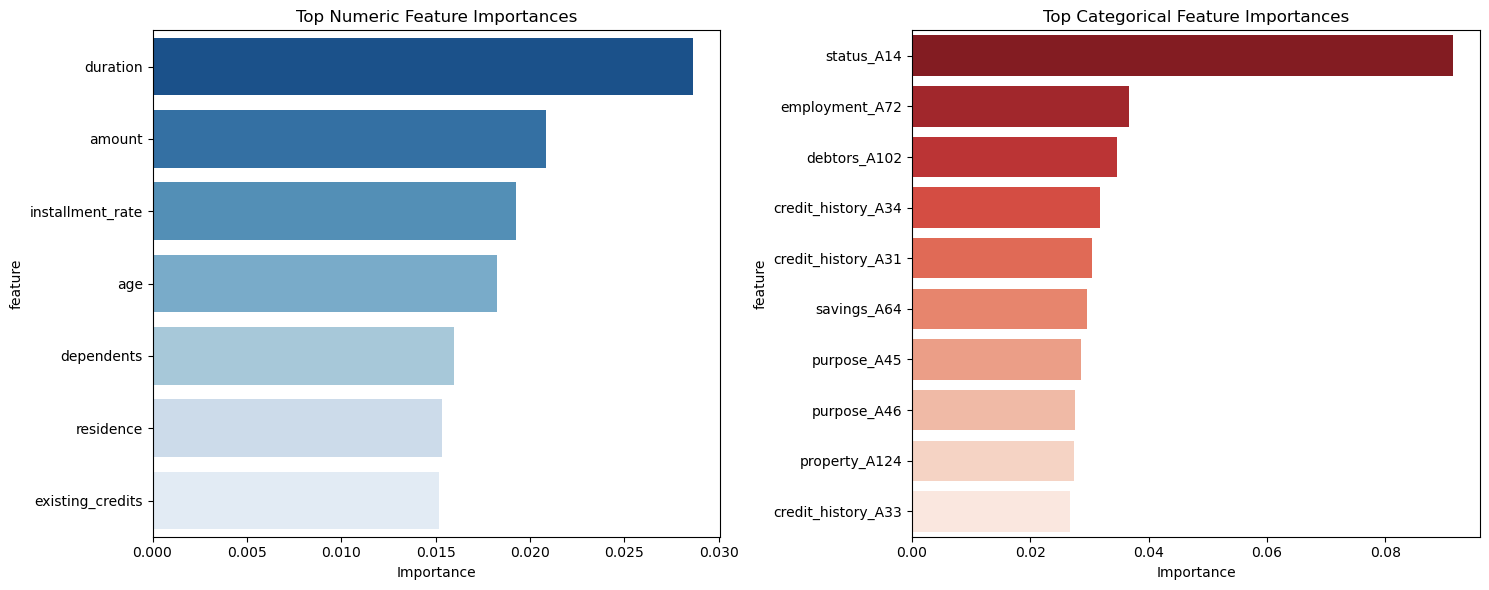

In [14]:
print("\n FEATURE IMPORTANCE ANALYSIS")
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 15 MOST IMPORTANT FEATURES:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances for Credit Risk Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Analyze feature importance by category
print("Feature Importance by Category:")

# Group by feature type
numeric_importance = feature_importance[
    feature_importance['feature'].isin(numeric_features)
]
categorical_importance = feature_importance[
    ~feature_importance['feature'].isin(numeric_features)
]

print(f"Top Numeric Features:")
print(numeric_importance.head(10))

print(f"Top Categorical Features:")
print(categorical_importance.head(10))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Numeric features
if len(numeric_importance) > 0:
    sns.barplot(data=numeric_importance.head(7), x='importance', y='feature', 
                ax=axes[0], palette='Blues_r')
    axes[0].set_title('Top Numeric Feature Importances')
    axes[0].set_xlabel('Importance')

# Categorical features  
if len(categorical_importance) > 0:
    sns.barplot(data=categorical_importance.head(10), x='importance', y='feature', 
                ax=axes[1], palette='Reds_r')
    axes[1].set_title('Top Categorical Feature Importances')
    axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [15]:
# BUSINESS INSIGHTS FROM FEATURE IMPORTANCE

In [16]:
print("\n BUSINESS INSIGHTS FROM FEATURE IMPORTANCE")


# Analyze top features
top_5_features = feature_importance.head(5)['feature'].tolist()
print(f"TOP 5 MOST PREDICTIVE FEATURES:")
for i, feature in enumerate(top_5_features, 1):
    importance_score = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
    print(f"{i}. {feature}: {importance_score:.4f}")

print(f"KEY BUSINESS INSIGHTS:")
print("1. Most important factors for default prediction:")
for feature in top_5_features:
    print(f"   - {feature}")

print(f"\n2. Feature categories ranked by average importance:")
avg_numeric = numeric_importance['importance'].mean() if len(numeric_importance) > 0 else 0
avg_categorical = categorical_importance['importance'].mean() if len(categorical_importance) > 0 else 0

if avg_numeric > avg_categorical:
    print("   - Numeric features are more predictive on average")
    print("   - Focus on quantitative risk factors")
else:
    print("   - Categorical features are more predictive on average") 
    print("   - Focus on qualitative risk factors")


 BUSINESS INSIGHTS FROM FEATURE IMPORTANCE
TOP 5 MOST PREDICTIVE FEATURES:
1. status_A14: 0.0914
2. employment_A72: 0.0366
3. debtors_A102: 0.0347
4. credit_history_A34: 0.0317
5. credit_history_A31: 0.0303
KEY BUSINESS INSIGHTS:
1. Most important factors for default prediction:
   - status_A14
   - employment_A72
   - debtors_A102
   - credit_history_A34
   - credit_history_A31

2. Feature categories ranked by average importance:
   - Categorical features are more predictive on average
   - Focus on qualitative risk factors


In [17]:
# PREDICTION FUNCTION WITH FEATURE IMPORTANCE

In [18]:
def predict_default(applicant_data):
    """
    Predict default risk for a new applicant
    
    Parameters:
    applicant_data: dict with applicant information
    
    Returns:
    prediction: 0 (good) or 1 (bad)
    probability: probability of default
    top_risk_factors: features contributing most to the decision
    """
    
    # Convert to DataFrame
    applicant_df = pd.DataFrame([applicant_data])
    
    # Ensure all columns are present
    for col in X.columns:
        if col not in applicant_df.columns:
            applicant_df[col] = 0  # Default value
    
    # Reorder columns to match training data
    applicant_df = applicant_df[X.columns]
    
    # Preprocess
    applicant_processed = preprocessor.transform(applicant_df)
    
    # Predict
    prediction = model.predict(applicant_processed)[0]
    probability = model.predict_proba(applicant_processed)[0][1]
    
    # Get feature contributions (simplified)
    feature_contributions = pd.DataFrame({
        'feature': feature_names,
        'value': applicant_processed[0],
        'importance': model.feature_importances_
    })
    
    # Calculate risk contribution (importance * normalized value)
    feature_contributions['risk_contribution'] = (
        feature_contributions['importance'] * np.abs(feature_contributions['value'])
    )
    
    top_risk_factors = feature_contributions.nlargest(5, 'risk_contribution')[['feature', 'risk_contribution']]
    
    return prediction, probability, top_risk_factors

In [19]:
# new user input prediction

In [23]:
def get_user_input():
    """Collects user input for prediction with user-friendly interface"""
    print("ENTER APPLICANT DETAILS FOR RISK ASSESSMENT")
    
    try:
        print("\n🏦 Please provide the following loan application details:")
        
        # Status (Checking account)
        print("\n1. Checking Account Status:")
        print("   A11 - Less than 0 DM")
        print("   A12 - 0 to 200 DM") 
        print("   A13 - More than 200 DM")
        print("   A14 - No checking account")
        status = input("   Enter status code: ").upper()
        
        # Duration
        duration = int(input("\n2. Loan duration (in months): "))
        
        # Credit History
        print("\n3. Credit History:")
        print("   A30 - No credits taken/all credits paid back duly")
        print("   A31 - All credits at this bank paid back duly")
        print("   A32 - Existing credits paid back duly till now")
        print("   A33 - Delay in paying off in the past")
        print("   A34 - Critical account/other credits existing")
        credit_history = input("   Enter credit history code: ").upper()
        
        # Purpose
        print("\n4. Loan Purpose:")
        print("   A40 - Car (new)")
        print("   A41 - Car (used)")
        print("   A42 - Furniture/equipment")
        print("   A43 - Radio/television")
        print("   A44 - Domestic appliances")
        print("   A45 - Repairs")
        print("   A46 - Education")
        print("   A47 - Vacation")
        print("   A48 - Retraining")
        print("   A49 - Business")
        print("   A410 - Others")
        purpose = input("   Enter purpose code: ").upper()
        
        # Amount
        amount = int(input("\n5. Credit amount (in DM): "))
        
        # Savings
        print("\n6. Savings Account/Bonds:")
        print("   A61 - Less than 100 DM")
        print("   A62 - 100 to 500 DM")
        print("   A63 - 500 to 1000 DM")
        print("   A64 - More than 1000 DM")
        print("   A65 - Unknown/no savings account")
        savings = input("   Enter savings code: ").upper()
        
        # Employment
        print("\n7. Present Employment Since:")
        print("   A71 - Unemployed")
        print("   A72 - Less than 1 year")
        print("   A73 - 1 to 4 years")
        print("   A74 - 4 to 7 years")
        print("   A75 - 7 or more years")
        employment = input("   Enter employment code: ").upper()
        
        # Installment rate
        print("\n8. Installment rate in percentage of disposable income:")
        installment_rate = int(input("   Enter rate (1-4): "))
        
        # Personal status
        print("\n9. Personal Status and Sex:")
        print("   A91 - Male divorced/separated")
        print("   A92 - Female divorced/separated/married")
        print("   A93 - Male single")
        print("   A94 - Male married/widowed")
        personal_status = input("   Enter personal status code: ").upper()
        
        # Debtors
        print("\n10. Other Debtors/Guarantors:")
        print("   A101 - None")
        print("   A102 - Co-applicant")
        print("   A103 - Guarantor")
        debtors = input("   Enter debtors code: ").upper()
        
        # Residence
        residence = int(input("\n11. Present residence since (1-4 years): "))
        
        # Property
        print("\n12. Property:")
        print("   A121 - Real estate")
        print("   A122 - Building society savings/life insurance")
        print("   A123 - Car or other")
        print("   A124 - Unknown/no property")
        property = input("   Enter property code: ").upper()
        
        # Age
        age = int(input("\n13. Age (in years): "))
        
        # Other plans
        print("\n14. Other Installment Plans:")
        print("   A141 - Bank")
        print("   A142 - Stores")
        print("   A143 - None")
        other_plans = input("   Enter other plans code: ").upper()
        
        # Housing
        print("\n15. Housing:")
        print("   A151 - Rent")
        print("   A152 - Own")
        print("   A153 - For free")
        housing = input("   Enter housing code: ").upper()
        
        # Existing credits
        existing_credits = int(input("\n16. Number of existing credits at this bank: "))
        
        # Job
        print("\n17. Job:")
        print("   A171 - Unemployed/unskilled non-resident")
        print("   A172 - Unskilled resident")
        print("   A173 - Skilled employee/official")
        print("   A174 - Management/self-employed/highly qualified")
        job = input("   Enter job code: ").upper()
        
        # Dependents
        dependents = int(input("\n18. Number of people being liable to provide maintenance: "))
        
        # Telephone
        print("\n19. Telephone:")
        print("   A191 - None")
        print("   A192 - Yes (registered under customer's name)")
        telephone = input("   Enter telephone code: ").upper()
        
        # Foreign
        print("\n20. Foreign Worker:")
        print("   A201 - Yes")
        print("   A202 - No")
        foreign = input("   Enter foreign worker code: ").upper()
        
        # Create applicant dictionary with exact same structure
        applicant = {
            'status': status,
            'duration': duration,
            'credit_history': credit_history,
            'purpose': purpose,
            'amount': amount,
            'savings': savings,
            'employment': employment,
            'installment_rate': installment_rate,
            'personal_status': personal_status,
            'debtors': debtors,
            'residence': residence,
            'property': property,
            'age': age,
            'other_plans': other_plans,
            'housing': housing,
            'existing_credits': existing_credits,
            'job': job,
            'dependents': dependents,
            'telephone': telephone,
            'foreign': foreign
        }
        
        print("\n✅ Application details collected successfully!")
        return applicant
        
    except ValueError:
        print("❌ Invalid input! Please enter numeric values for numeric fields.")
        return None
# Clean and simple - replace your current ending with this:

print("\n CREDIT RISK PREDICTION SYSTEM")


# Direct interactive prediction
new_applicant = get_user_input()

if new_applicant:
    pred, prob, factors = predict_default(new_applicant)
    print(f"\nRESULT:")
    print(f"Status: {'🔴HIGH RISK' if pred == 1 else '🟢LOW RISK'}")
    print("Lesser the Default vaule more trusted user!!")
    print(f"Default Probability: {prob:.1%}")
    print(f"\nKey Risk Factors: {factors}")
else:
    print("❌ Input failed. Please try again.")




 CREDIT RISK PREDICTION SYSTEM
ENTER APPLICANT DETAILS FOR RISK ASSESSMENT

🏦 Please provide the following loan application details:

1. Checking Account Status:
   A11 - Less than 0 DM
   A12 - 0 to 200 DM
   A13 - More than 200 DM
   A14 - No checking account


   Enter status code:  a13

2. Loan duration (in months):  18



3. Credit History:
   A30 - No credits taken/all credits paid back duly
   A31 - All credits at this bank paid back duly
   A32 - Existing credits paid back duly till now
   A33 - Delay in paying off in the past
   A34 - Critical account/other credits existing


   Enter credit history code:  a31



4. Loan Purpose:
   A40 - Car (new)
   A41 - Car (used)
   A42 - Furniture/equipment
   A43 - Radio/television
   A44 - Domestic appliances
   A45 - Repairs
   A46 - Education
   A47 - Vacation
   A48 - Retraining
   A49 - Business
   A410 - Others


   Enter purpose code:  a42

5. Credit amount (in DM):  5000



6. Savings Account/Bonds:
   A61 - Less than 100 DM
   A62 - 100 to 500 DM
   A63 - 500 to 1000 DM
   A64 - More than 1000 DM
   A65 - Unknown/no savings account


   Enter savings code:  a63



7. Present Employment Since:
   A71 - Unemployed
   A72 - Less than 1 year
   A73 - 1 to 4 years
   A74 - 4 to 7 years
   A75 - 7 or more years


   Enter employment code:  a74



8. Installment rate in percentage of disposable income:


   Enter rate (1-4):  2



9. Personal Status and Sex:
   A91 - Male divorced/separated
   A92 - Female divorced/separated/married
   A93 - Male single
   A94 - Male married/widowed


   Enter personal status code:  a92



10. Other Debtors/Guarantors:
   A101 - None
   A102 - Co-applicant
   A103 - Guarantor


   Enter debtors code:  a101

11. Present residence since (1-4 years):  3



12. Property:
   A121 - Real estate
   A122 - Building society savings/life insurance
   A123 - Car or other
   A124 - Unknown/no property


   Enter property code:  a122

13. Age (in years):  38



14. Other Installment Plans:
   A141 - Bank
   A142 - Stores
   A143 - None


   Enter other plans code:  a141



15. Housing:
   A151 - Rent
   A152 - Own
   A153 - For free


   Enter housing code:  a153

16. Number of existing credits at this bank:  1



17. Job:
   A171 - Unemployed/unskilled non-resident
   A172 - Unskilled resident
   A173 - Skilled employee/official
   A174 - Management/self-employed/highly qualified


   Enter job code:  a173

18. Number of people being liable to provide maintenance:  1



19. Telephone:
   A191 - None
   A192 - Yes (registered under customer's name)


   Enter telephone code:  a192



20. Foreign Worker:
   A201 - Yes
   A202 - No


   Enter foreign worker code:  a202



✅ Application details collected successfully!

RESULT:
Status: 🟢LOW RISK
Lesser the Default vaule more trusted user!!
Default Probability: 25.5%

Key Risk Factors:                feature  risk_contribution
10  credit_history_A31           0.030328
29      employment_A74           0.023451
8           status_A13           0.021531
47        foreign_A202           0.018767
16         purpose_A42           0.017112
